**In this guide, we'll explore how to generate content for a solo podcast using LangChain, LLMs, and ElevenLabs. The podcast topic can be any interesting subject sourced from Wikipedia.**

In [ ]:
from getpass import getpass

api_key = getpass('Enter your OPENAI_API_KEY')

In [ ]:
from getpass import getpass

eleven_labs_api_key = getpass('Enter your ELEVEN_LABS_API_KEY')

install dependencies

In [ ]:
!pip install wikipedia tiktoken langchain_community langchain_experimental langchain_openai langgraph elevenlabs pydub --quiet

Download podcast content

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="Indian_Premier_League", load_max_docs=3).load()
len(docs)
for doc in docs:
    print(doc.metadata)

{'title': 'Indian Premier League', 'summary': "The Indian Premier League (IPL) is a professional Twenty20 cricket league in India organised by the Board of Control for Cricket in India (BCCI). Founded in 2007, the league features ten state or city-based franchise teams. The IPL is the most popular and richest cricket league in the world and is held between March and May. It has an exclusive window in the ICC Future Tours Programme, resulting in fewer international cricket tours occurring during the IPL seasons. It is also the most viewed sports competition in India, as per BARC.\nIn 2014, it ranked sixth in attendance among all sports leagues. In 2010, the IPL became the first sporting event to be broadcast live on YouTube. Inspired by the success of the IPL, other Indian sports leagues have been established. In 2022, the league's brand value was estimated at ₹90,038 crore (US$11 billion). According to the BCCI, the 2015 IPL season contributed ₹1,150 crore (US$140 million) to India's G

Split the content into chunks

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

text_splitter = SemanticChunker(
    OpenAIEmbeddings(api_key=api_key), breakpoint_threshold_type="gradient"
)
split_docs = text_splitter.split_documents(docs)
len(split_docs)

9

In [ ]:
split_docs[0].page_content

"The Indian Premier League (IPL) is a professional Twenty20 cricket league in India organised by the Board of Control for Cricket in India (BCCI). Founded in 2007, the league features ten state or city-based franchise teams. The IPL is the most popular and richest cricket league in the world and is held between March and May. It has an exclusive window in the ICC Future Tours Programme, resulting in fewer international cricket tours occurring during the IPL seasons. It is also the most viewed sports competition in India, as per BARC. In 2014, it ranked sixth in attendance among all sports leagues. In 2010, the IPL became the first sporting event to be broadcast live on YouTube. Inspired by the success of the IPL, other Indian sports leagues have been established. In 2022, the league's brand value was estimated at ₹90,038 crore (US$11 billion). According to the BCCI, the 2015 IPL season contributed ₹1,150 crore (US$140 million) to India's GDP. In December 2022, the IPL achieved a valuat

Summarizing long content with MapReduceDocumentsChain in Langchain

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = api_key

llm = init_chat_model("gpt-4o-mini", model_provider="openai",temperature = 0.7)

# Map
map_template = """
You are a Sports enthusiast who is doing a research for a podcast. Your task is to extract relevant information from the Result delimited by triple quotes.
Please identify 3 interesting questions and answers which can be used for a podcast discussion.
The identified discussions should be returned in the following format.
- Highlight 1 from the text
- Highlight 2 from the text
- Highlight 3 from the text
Result: {docs}"""

# Reduce
reduce_template ="""
You are a writer creating the script for the another episode of a podcast "Sport 101" hosted by \"Tom\".
Make the podcast casual, engaging and informative
Extract relevant information for the solo podcast from the Result delimited by triple quotes.
Use \"Tom\" as the person speaking and sharing insights about the topic with the audience.
Use the below format for the solo podcast.
1. Introduction about the topic and welcome everyone for another episode of the podcast "Sport 101".
2. Introduce the speaker in brief.
3. Then start the podcast.
4. Start the podcast with some casual discussion like what he is doing right now at this moment.
5. End the podcast with thank you speech to everyone.
6. Do not use the word \"conversation\" in the response.
7. Do not use the word \"Introduction\" in the response.
8. Do not use the word \"Podcast Script\" in response.
Result: "{doc_summaries}"
"""

map_prompt = ChatPromptTemplate([("human", map_template)])
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

map_chain = map_prompt | llm | StrOutputParser()
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [ ]:
import operator
from typing import Annotated, List, TypedDict
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["summaries"])
    return {"final_summary": response}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)
graph.add_node("generate_final_summary", generate_final_summary)
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "generate_final_summary")
graph.add_edge("generate_final_summary", END)
app = graph.compile()

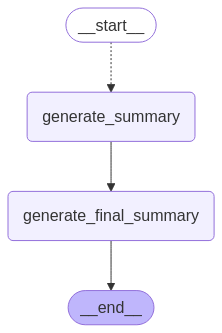

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph:
async for step in app.astream({"contents": [doc.page_content for doc in split_docs]}):
    print(step)

{'generate_summary': {'summaries': ['It seems that the text provided is incomplete and does not contain sufficient information to extract relevant discussions or questions. Please provide a more complete passage or additional context related to your research on sports for your podcast.']}}
{'generate_summary': {'summaries': ['- What makes the Twenty20 tournament the most watched cricket event? \n- How does the financial aspect of the Twenty20 tournament compare to other cricket leagues worldwide?\n- What factors contribute to the popularity of the Twenty20 format in cricket?']}}
{'generate_summary': {'summaries': ['- **What is the Indian Premier League (IPL)?**  \n  The IPL is a domestic, annual Twenty20 cricket tournament played in India.\n\n- **Who organizes the IPL?**  \n  The IPL is organized by the IPL Governing Council, which operates under the Board of Control for Cricket in India (BCCI).\n\n- **What format of cricket is played in the IPL?**  \n  The tournament is played in the 

In [ ]:
podcastScript = step.get('generate_final_summary').get('final_summary')
print(podcastScript)

Hey there, sports fans! Welcome back to another exciting episode of "Sport 101." I'm your host, Tom, and today, we're diving into the fascinating world of the Indian Premier League, or IPL as we all know it. This tournament isn't just a cricket competition; it’s a phenomenon that has reshaped the landscape of sports in India and beyond.

For those who might be new to the scene, the IPL is a professional Twenty20 cricket league that has gained immense popularity and wealth since its inception. With a staggering brand value estimated at about ₹90,038 crore (that’s around US$11 billion!), it’s no wonder that the IPL is often considered the richest cricket league in the world.

So, what's on my plate today? Well, as I sit here sipping my morning coffee, I can’t help but think about the buzz surrounding the IPL and its impact not only on cricket but also on the economy. Did you know that just the 2015 season contributed a whopping ₹1,150 crore (approximately US$140 million) to India’s GDP? 

In [ ]:
from elevenlabs.client import ElevenLabs

client = ElevenLabs(
  api_key=eleven_labs_api_key,
)

response = client.voices.get_all()
print(response.voices)

[Voice(voice_id='9BWtsMINqrJLrRacOk9x', name='Aria', samples=None, category='premade', fine_tuning=FineTuningResponse(is_allowed_to_fine_tune=True, state={'eleven_multilingual_v2': 'fine_tuned', 'eleven_turbo_v2_5': 'fine_tuned', 'eleven_flash_v2_5': 'fine_tuned', 'eleven_v2_flash': 'fine_tuned', 'eleven_v2_5_flash': 'fine_tuned', 'eleven_turbo_v2': 'fine_tuned', 'eleven_flash_v2': 'fine_tuned'}, verification_failures=[], verification_attempts_count=0, manual_verification_requested=False, language='en', progress={'eleven_flash_v2_5': 1.0, 'eleven_v2_flash': 1.0, 'eleven_flash_v2': 1.0, 'eleven_v2_5_flash': 1.0}, message={'eleven_flash_v2_5': 'Done!', 'eleven_v2_flash': 'Done!', 'eleven_flash_v2': 'Done!', 'eleven_v2_5_flash': 'Done!'}, dataset_duration_seconds=None, verification_attempts=None, slice_ids=None, manual_verification=None, max_verification_attempts=5, next_max_verification_attempts_reset_unix_ms=1700000000000, finetuning_state=None), labels={'accent': 'american', 'descripti

In [ ]:
from elevenlabs.client import ElevenLabs

client = ElevenLabs(
  api_key=eleven_labs_api_key,
)

def createPodcast(podcastScript, speakerChoice):
  genPodcast = []
  podcastLines = podcastScript.split('\n\n')
  for line in podcastLines:
    print(line)
    genVoice = client.generate(text=line, voice=speakerChoice, model="eleven_multilingual_v2")
    # Change: Iterate through the generator and write bytes to a bytearray
    audio_bytes = bytearray()
    for chunk in genVoice:
        audio_bytes.extend(chunk)
    genPodcast.append(audio_bytes)  # Append bytearray to genPodcast
  return genPodcast

In [ ]:
speakerName1 = "Tom"
speakerChoice1 = "Sports Guy - Excited and fast, giving you that play by play."
genPodcast = createPodcast(podcastScript, speakerChoice1)

Hey there, sports fans! Welcome back to another exciting episode of "Sport 101." I'm your host, Tom, and today, we're diving into the fascinating world of the Indian Premier League, or IPL as we all know it. This tournament isn't just a cricket competition; it’s a phenomenon that has reshaped the landscape of sports in India and beyond.
For those who might be new to the scene, the IPL is a professional Twenty20 cricket league that has gained immense popularity and wealth since its inception. With a staggering brand value estimated at about ₹90,038 crore (that’s around US$11 billion!), it’s no wonder that the IPL is often considered the richest cricket league in the world.
So, what's on my plate today? Well, as I sit here sipping my morning coffee, I can’t help but think about the buzz surrounding the IPL and its impact not only on cricket but also on the economy. Did you know that just the 2015 season contributed a whopping ₹1,150 crore (approximately US$140 million) to India’s GDP? Th

In [ ]:
with open("/content/sample_data/genPodcast.mpeg", "wb") as f:
  for pod in genPodcast:
    f.write(pod)

In [ ]:
from pydub import AudioSegment
AudioSegment.from_file("/content/sample_data/genPodcast.mpeg").export("/content/sample_data/genPodcast.mp3", format="mp3")

<_io.BufferedRandom name='/content/sample_data/genPodcast.mp3'>

Generate a Ghibli-style image using a reference image with the below prompt:
Convert the image into and anime style using immersive realism similar at 99.99% to Studio Ghiblis style but not the same but similar so it's not infrigment

This is the most exciting part of our podcast creation! We have our podcast audio script ready, along with a Ghibli-style podcast image. Now, we can use Hedra to generate the podcast video using the image and audio script.
